# Predicting equity market pullbacks (a.k.a SIREN)

## Problem Statement

XX

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

In [2]:
# Ensuring our notebook remains tidy
import warnings
warnings.filterwarnings('ignore') # Ensuring the notebook remains tidy

In [3]:
# Deciding our colour schemes
sns.set_style('darkgrid')
sns.set_palette("icefire")

### List of sub-dataset(s)
* ```eri_tidied```: S&P 500 earnings revision
* ```cesi_tidied```: Citi economic surprise indices (1w, 1m, 3m, 6m changes)
* ```prices_4w_return```: 4-week rolling percentage returns of various indices (Lagged)
* ```vol```: Volatility indices
* ```fpe_tidied```: 12-month forward P/E ratios (1m, 3m, 6m % changes)
* ```fpb_tidied```: 12-month forward P/B ratios (1m, 3m, 6m % changes); **May need to be adjusted**
* ```finc```: Financial condition indices; **Chicago Fed Financial Conditions are inverted relative to the BBG ones**
* ```como```: Commodity front-end contracts and total return indices (1m, 3m, 6m % changes)
* ```us_ir_tidied```: US interest rates, including 10y/2y and 30y/2y spreads (1w, 1m, 3m, 6m changes)
* ```eu_ir_tidied```: Eurozone interest rates, including 10y/2y and 30y/2y spreads (1w, 1m, 3m, 6m changes)
* ```aaii```: AAII investor sentiment survey
* ```credit_tidied```: Credit spreads (1w, 1m, 3m, 6m changes; In %)
* ```pct52w_h```: Breadth data; Percentage of index members with new 52-week highs
* ```spx_cftc```: CFTC net non-commercial data for S&P 500 futures
* ```putcall```: Put-call ratios for S&P 500
* ```epu```: Economic policy uncertainty indices
* ```usd```: USD indices (Trade-weighted, DXY, BBDXY)

## Data collection + cleaning

#### Earnings revision ratios

In [4]:
# Read .xlsx highlighting S&P 500's earnings revisions
eri = pd.read_excel("../data/spx_eri.xlsx", sheet_name="Combined")
print(eri.shape)
eri.head()

(862, 3)


,date,upgrades,downgrades
0,2005-07-01,11,11
1,2005-07-08,36,25
2,2005-07-15,96,59
3,2005-07-22,190,94
4,2005-07-29,242,117


In [5]:
# Standardise dates for compilation later
eri['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in eri['date']]

In [6]:
# Check dates
eri.head()

,date,upgrades,downgrades
0,2005-07-01,11,11
1,2005-07-08,36,25
2,2005-07-15,96,59
3,2005-07-22,190,94
4,2005-07-29,242,117


In [7]:
eri.set_index('date', inplace=True)

In [8]:
# Computing upgrade / downgrade ratios
eri['net'] = eri['upgrades'] / eri['downgrades'] - 1

# Calculate 3-month rolling average (This will be our ERI)
eri['eri'] = eri['net'].rolling(13).mean()

In [9]:
# Calculate 1-month change
eri['eri_1m_chg'] = eri['eri'].diff(4)

# Calculate 3-month change
eri['eri_3m_chg'] = eri['eri'].diff(13)

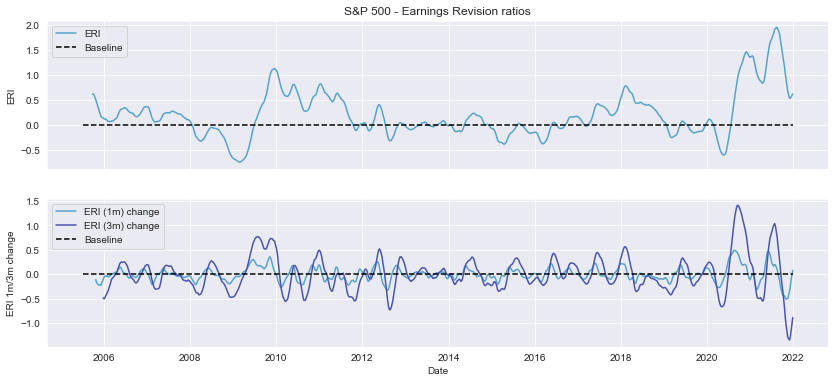

In [10]:
# Let's visualise our ERI
fig, axes = plt.subplots(nrows=2, figsize=(14,6), sharex=True)
sns.lineplot(data=eri, x='date', y='eri', ax=axes[0], label="ERI")
sns.lineplot(data=eri, x='date', y=0, ax=axes[0], linestyle="--", color="black", label="Baseline")

sns.lineplot(data=eri, x='date', y='eri_1m_chg', ax=axes[1], label="ERI (1m) change")
sns.lineplot(data=eri, x='date', y='eri_3m_chg', ax=axes[1], label="ERI (3m) change")
sns.lineplot(data=eri, x='date', y=0, ax=axes[1], linestyle="--", color="black", label="Baseline")

axes[0].set_title("S&P 500 - Earnings Revision ratios")
axes[0].set_ylabel("ERI")
axes[1].set_ylabel("ERI 1m/3m change")
axes[1].legend()
plt.xlabel("Date")
plt.show()

In [11]:
# Preparing dataset to be merged
eri_tidied = eri[['eri', 'eri_1m_chg', 'eri_3m_chg']]

#### Economic surprise indices

In [12]:
# Read .xlsx containing Citi Economic Surprise Indices
cesi = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="econ_sur", skiprows=11)
print(cesi.shape)
cesi.head()

(866, 7)


,date,cesiusd,cesieur,cesigbp,cesijpy,cesicny,cesiglf
0,2005-07-01,1.8,-42.9,-16.2,53.2,25.1,-3.1
1,2005-07-08,7.3,-19.4,-6.9,37.8,23.8,1.4
2,2005-07-15,25.2,-9.6,-4.0,31.1,40.9,10.6
3,2005-07-22,17.9,29.9,30.6,27.7,57.0,19.6
4,2005-07-29,25.0,65.7,27.7,32.8,55.7,30.7


In [13]:
# Standardise dates for compilation later
cesi['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in cesi['date']]

In [14]:
# Check dates
cesi.head()

,date,cesiusd,cesieur,cesigbp,cesijpy,cesicny,cesiglf
0,2005-07-01,1.8,-42.9,-16.2,53.2,25.1,-3.1
1,2005-07-08,7.3,-19.4,-6.9,37.8,23.8,1.4
2,2005-07-15,25.2,-9.6,-4.0,31.1,40.9,10.6
3,2005-07-22,17.9,29.9,30.6,27.7,57.0,19.6
4,2005-07-29,25.0,65.7,27.7,32.8,55.7,30.7


In [15]:
# Setting 'date' as an index
cesi.set_index('date', inplace=True)

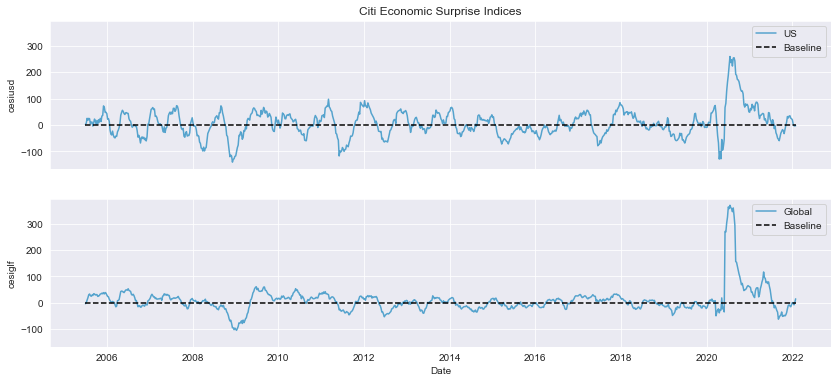

In [16]:
# Let's visualise these trends
fig, axes = plt.subplots(nrows=2, figsize=(14,6), sharex=True, sharey=True)
sns.lineplot(data=cesi, x='date', y='cesiusd', ax=axes[0], label="US")
sns.lineplot(data=cesi, x='date', y=0, ax=axes[0], linestyle="--", color="black", label="Baseline")

sns.lineplot(data=cesi, x='date', y='cesiglf', ax=axes[1], label="Global")
sns.lineplot(data=cesi, x='date', y=0, ax=axes[1], linestyle="--", color="black", label="Baseline")

axes[0].set_title("Citi Economic Surprise Indices")
axes[0].legend()
axes[1].legend()
plt.xlabel("Date")
plt.show()

**Definition**

For the layman, XX

In [17]:
# Calculating 1-week differences
cesi_1w = cesi.diff(1)

# Calculating 4-week differences
cesi_4w = cesi.diff(4)

# Calculating quarterly changes (13-week) differences
cesi_13w = cesi.diff(13)

# Calculating half-yearly changes (26-week) differences
cesi_26w = cesi.diff(26)

In [18]:
# We will combine the dataframes above and add suffixes
cesi_tidied = pd.concat([cesi_1w.add_suffix("_1w_chg"), cesi_4w.add_suffix("_4w_chg"), 
                         cesi_13w.add_suffix("_13w_chg"), cesi_26w.add_suffix("_26w_chg")], axis=1)

In [19]:
# Preview dataframe
cesi_tidied.tail()

,cesiusd_1w_chg,cesieur_1w_chg,cesigbp_1w_chg,cesijpy_1w_chg,cesicny_1w_chg,cesiglf_1w_chg,cesiusd_4w_chg,cesieur_4w_chg,cesigbp_4w_chg,cesijpy_4w_chg,...,cesigbp_13w_chg,cesijpy_13w_chg,cesicny_13w_chg,cesiglf_13w_chg,cesiusd_26w_chg,cesieur_26w_chg,cesigbp_26w_chg,cesijpy_26w_chg,cesicny_26w_chg,cesiglf_26w_chg
date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,-4.1,3.2,-14.7,16.0,-1.3,8.0,-14.1,24.1,-19.9,65.2,...,67.7,54.0,86.4,35.5,5.2,-79.7,-48.3,-40.7,104.8,-24.4
2022-01-07,-15.9,10.7,0.7,2.6,5.8,-1.9,-31.4,33.5,-17.1,44.7,...,67.5,68.9,100.2,50.1,3.9,-46.6,-27.5,-32.7,97.6,-5.2
2022-01-14,-6.5,-4.6,10.1,16.0,-2.8,-6.4,-28.8,24.8,-19.1,35.1,...,65.2,87.5,95.4,42.8,-22.8,-38.1,-27.4,8.8,73.2,-14.1
2022-01-21,-0.5,4.5,-16.7,7.3,22.5,8.1,-27.0,13.8,-20.6,41.9,...,35.5,81.0,117.6,47.6,-12.1,-24.8,-14.0,10.3,91.6,4.9
2022-01-28,0.7,10.3,-9.3,8.6,-3.2,14.5,-22.2,20.9,-15.2,34.5,...,18.6,113.3,107.7,64.7,11.1,10.3,-11.3,24.1,83.6,34.1


#### Price indices

In [20]:
# Read .xlsx containing Citi Economic Surprise Indices
prices = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="eq_indices", skiprows=11)
print(prices.shape)
prices.head()

(866, 7)


,date,spx,sx5e,ftse100,tpx,msci_axj,msci_acw
0,2005-07-01,1194.44,3208.61,5161.0,1181.80,305.28,280.30
1,2005-07-08,1211.86,3224.59,5232.2,1177.61,300.98,282.22
2,2005-07-15,1227.92,3278.71,5230.8,1193.30,311.98,286.68
3,2005-07-22,1233.68,3292.92,5241.8,1186.76,320.35,289.00
4,2005-07-29,1234.18,3326.51,5282.3,1204.98,322.50,290.57


In [21]:
# Standardise dates for compilation later
prices['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in prices['date']]

In [22]:
prices.set_index('date', inplace=True)

In [23]:
# Define period of interest
period = 4

# We will compute the n-week percentage difference of stocks and shift the returns back
## By doing so, this ensures that our features are forward-looking
prices_4w_return = prices.pct_change(period).shift(-period)*100

# Preview dataframe
prices_4w_return.head()

,spx,sx5e,ftse100,tpx,msci_axj,msci_acw
date,,,,,,
2005-07-01,3.327082,3.674488,2.350320,1.961415,5.640723,3.663932
2005-07-08,1.201459,1.733554,1.576775,0.983348,8.379294,3.072071
2005-07-15,0.201153,1.690909,2.198516,4.343417,5.333675,3.153342
2005-07-22,-1.132384,1.070478,1.350681,5.370926,-0.799126,0.785467
2005-07-29,-2.356220,-3.078602,-1.026068,5.600093,-2.071318,-0.251230


In [24]:
prices_4w_return.rename(columns={"spx": "S&P 500", "sx5e": "Stoxx 50","ftse100": "FTSE 100", 
                                 "tpx":"Topix", "msci_axj": "MSCI Asia ex-Japan",
                                 "msci_acw": "MSCI All-Country World"}, inplace=True)

prices_4w_return_melt = prices_4w_return.melt(var_name="Index", value_name="4w_returns")

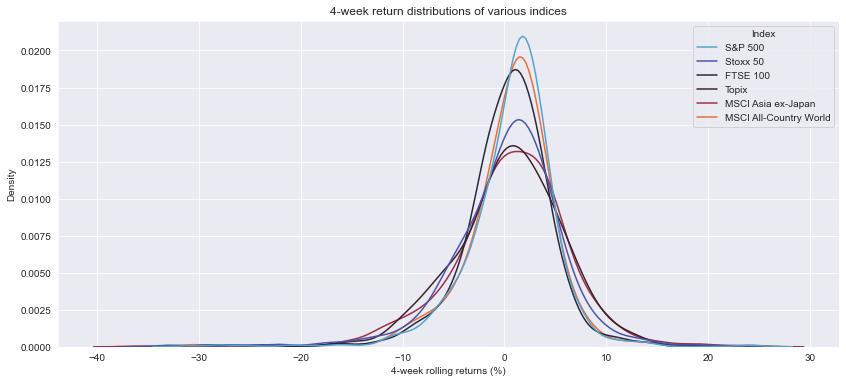

In [25]:
# Let's visualise the distributions of monthly returns
fig, axes = plt.subplots(nrows=1, figsize=(14,6), sharex=True, sharey=True)
sns.kdeplot(data=prices_4w_return_melt, x="4w_returns", hue="Index")
plt.title("4-week return distributions of various indices")
plt.xlabel("4-week rolling returns (%)")
plt.show()

#### Volatility indices

In [26]:
# Read .xlsx containing various volatility indices
vol = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="vol", skiprows=11)
print(vol.shape)
vol.head()

(866, 5)


,date,vix,move,cvix,skew
0,2005-07-01,11.40,78.85,8.332496,123.58
1,2005-07-08,11.45,80.12,8.527097,125.02
2,2005-07-15,10.33,77.50,8.253075,122.48
3,2005-07-22,10.52,75.54,8.340634,123.71
4,2005-07-29,11.57,74.80,8.244925,121.30


In [27]:
# Standardise dates for compilation later
vol['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in vol['date']]

In [28]:
# Setting date as our index
vol.set_index('date', inplace=True)

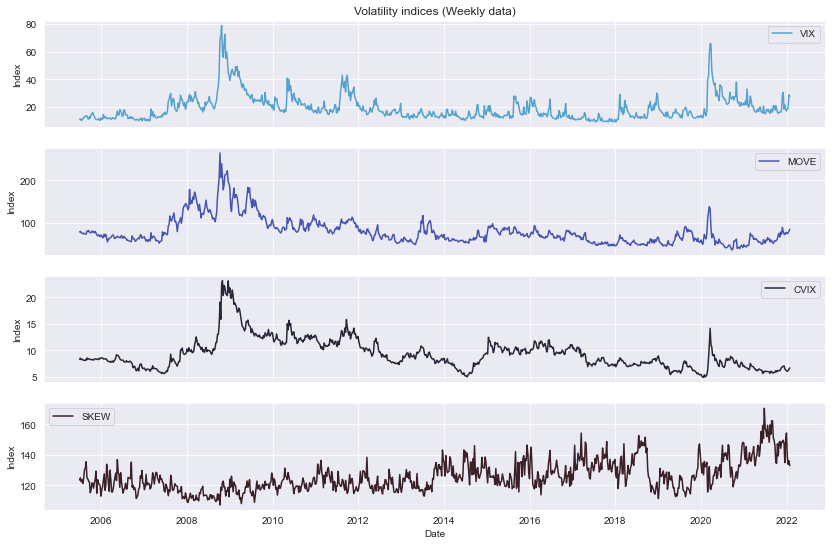

In [29]:
# Let's visualise these trends
fig, axes = plt.subplots(nrows=4, figsize=(14,9), sharex=True, sharey=False)
sns.lineplot(data=vol, x='date', y='vix', ax=axes[0], color=sns.color_palette("icefire")[0], label="VIX")
sns.lineplot(data=vol, x='date', y='move', ax=axes[1], color=sns.color_palette("icefire")[1], label="MOVE")
sns.lineplot(data=vol, x='date', y='cvix', ax=axes[2], color=sns.color_palette("icefire")[2], label="CVIX")
sns.lineplot(data=vol, x='date', y='skew', ax=axes[3], color=sns.color_palette("icefire")[3], label="SKEW")

axes[0].set_title("Volatility indices (Weekly data)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

axes[0].set_ylabel("Index")
axes[1].set_ylabel("Index")
axes[2].set_ylabel("Index")
axes[3].set_ylabel("Index")
plt.xlabel("Date")
plt.show()

#### 12-month forward P/E ratios

In [30]:
# Read .xlsx containing p/e ratios for a variety of indices
fpe = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="pe", skiprows=11)
print(fpe.shape)
fpe.head()

(866, 7)


,date,spx,sx5e,ftse100,tpx,msci_axj,msci_acw
0,2005-07-01,16.0415,12.8541,6.2942,15.3679,12.3141,12.3141
1,2005-07-08,16.2689,12.7161,5.9493,15.1616,12.4434,12.4434
2,2005-07-15,16.4594,13.0344,8.0495,15.3828,12.8345,12.8345
3,2005-07-22,16.5001,13.0778,8.7900,15.3124,13.3287,13.3287
4,2005-07-29,16.3927,13.2365,9.1949,15.5419,13.1646,13.1646


In [31]:
# Standardise dates for compilation later
fpe['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in fpe['date']]

In [32]:
# Setting date as our index
fpe.set_index('date', inplace=True)

In [33]:
# Melting our dataframe
fpe.rename(columns={"spx": "S&P 500", "sx5e": "Stoxx 50","ftse100": "FTSE 100", 
                    "tpx":"Topix", "msci_axj": "MSCI Asia ex-Japan",
                    "msci_acw": "MSCI All-Country World"}, inplace=True)

fpe_melt = fpe.melt(var_name="Index", value_name="pe_ratios")

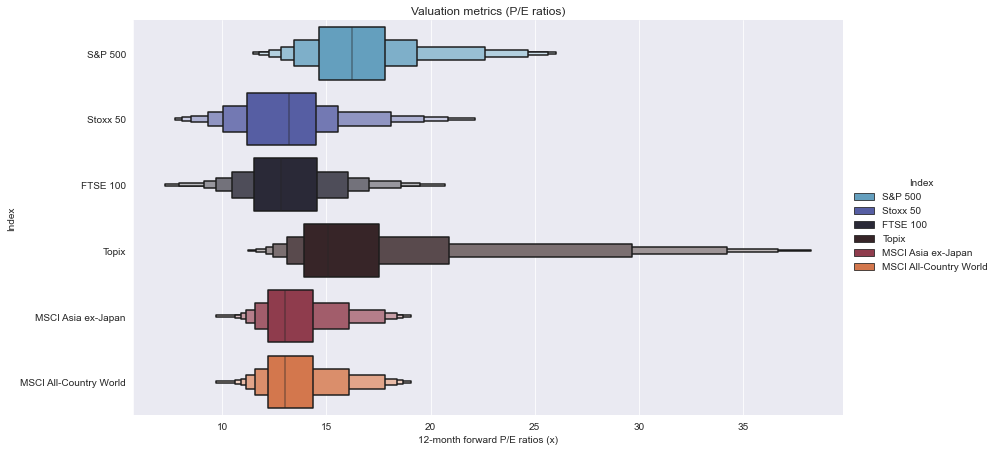

In [34]:
# Let's visualise the distributions of P/E ratios
sns.catplot(data=fpe_melt, y="Index", x="pe_ratios", hue="Index", 
            kind='boxen', showfliers = False, # Outliers had to be removed for Topix
            dodge=False, aspect=2, height=6) 
plt.title("Valuation metrics (P/E ratios)")
plt.xlabel("12-month forward P/E ratios (x)")
plt.show()

In [35]:
# Calculating 4-week differences
fpe_4w = fpe.pct_change(4)*100

# Calculating quarterly changes (13-week) differences
fpe_13w = fpe.pct_change(13)*100

# Calculating half-yearly changes (26-week) differences
fpe_26w = fpe.pct_change(26)*100

In [36]:
# We will combine the dataframes above and add suffixes
fpe_tidied = pd.concat([fpe_4w.add_suffix("_4w_chg"), 
                        fpe_13w.add_suffix("_13w_chg"), 
                        fpe_26w.add_suffix("_26w_chg")], axis=1)

In [37]:
# Preview dataframe
fpe_tidied.tail()

,S&P 500_4w_chg,Stoxx 50_4w_chg,FTSE 100_4w_chg,Topix_4w_chg,MSCI Asia ex-Japan_4w_chg,MSCI All-Country World_4w_chg,S&P 500_13w_chg,Stoxx 50_13w_chg,FTSE 100_13w_chg,Topix_13w_chg,MSCI Asia ex-Japan_13w_chg,MSCI All-Country World_13w_chg,S&P 500_26w_chg,Stoxx 50_26w_chg,FTSE 100_26w_chg,Topix_26w_chg,MSCI Asia ex-Japan_26w_chg,MSCI All-Country World_26w_chg
date,,,,,,,,,,,,,,,,,,
2021-12-31,5.213946,5.891125,3.871307,0.679232,0.465604,0.465604,5.952781,2.135865,2.221449,-1.198852,0.424387,0.424387,-0.407444,-9.586455,-7.323572,-7.529205,-7.192004,-7.192004
2022-01-07,-5.132878,-3.161485,-0.667079,-0.080130,-6.773424,-6.773424,-1.554563,-4.929577,-1.274084,-0.368924,-6.579832,-6.579832,-7.067569,-14.545616,-8.312438,-5.438875,-10.412638,-10.412638
2022-01-14,-3.654220,-3.179881,0.134419,-1.470210,-3.261106,-3.261106,-3.414877,-7.887915,-2.818464,-4.556371,-7.121369,-7.121369,-5.746435,-13.885047,-5.891386,-7.212975,-11.047642,-11.047642
2022-01-21,-11.356702,-8.505811,-3.207887,-4.071511,-4.826715,-4.826715,-9.750683,-10.276456,-3.709444,-6.113112,-9.104690,-9.104690,-11.892770,-16.733639,-6.702161,-8.368938,-9.753801,-9.753801
2022-01-28,-11.754992,-11.859437,-3.396770,-7.073074,-10.096038,-10.096038,-10.217752,-12.970955,-4.530157,-9.456218,-11.455200,-11.455200,-9.240991,-17.347276,-6.606128,-10.130156,-10.794431,-10.794431


#### 12-month forward P/B ratios

In [38]:
# Read .xlsx containing p/b ratios for a variety of indices
fpb = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="pb", skiprows=11)
print(fpb.shape)
fpb.head()

(866, 7)


,date,spx,sx5e,ftse100,tpx,msci_axj,msci_acw
0,2005-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-07-08,NaN,2.2257,2.3495,NaN,1.7540,1.7540
2,2005-07-15,NaN,2.3037,2.2945,NaN,1.8784,1.8784
3,2005-07-22,NaN,2.2267,0.6976,NaN,1.9416,1.9416
4,2005-07-29,NaN,2.1999,0.7800,NaN,1.9266,1.9266


In [39]:
# Standardise dates for compilation later
fpb['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in fpb['date']]

In [40]:
# Setting date as our index
fpb.set_index('date', inplace=True)

In [41]:
# Melting our dataframe
fpb.rename(columns={"spx": "S&P 500", "sx5e": "Stoxx 50","ftse100": "FTSE 100", 
                    "tpx":"Topix", "msci_axj": "MSCI Asia ex-Japan",
                    "msci_acw": "MSCI All-Country World"}, inplace=True)

fpb_melt = fpe.melt(var_name="Index", value_name="pb_ratios")

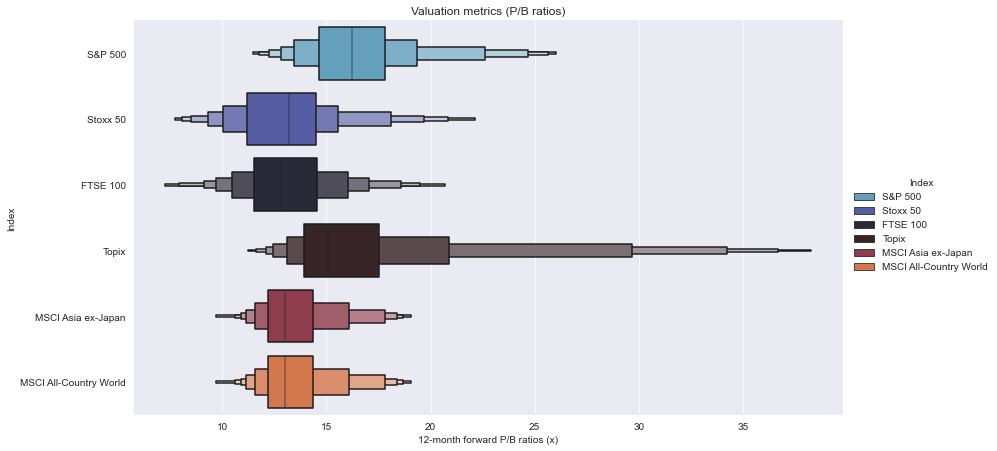

In [42]:
# Let's visualise the distributions of P/B ratios
sns.catplot(data=fpb_melt, y="Index", x="pb_ratios", hue="Index", 
            kind='boxen', showfliers = False, # Outliers had to be removed for Topix
            dodge=False, aspect=2, height=6) 
plt.title("Valuation metrics (P/B ratios)")
plt.xlabel("12-month forward P/B ratios (x)")
plt.show()

In [43]:
# Calculating 4-week differences
fpb_4w = fpb.pct_change(4)*100

# Calculating quarterly changes (13-week) differences
fpb_13w = fpb.pct_change(13)*100

# Calculating half-yearly changes (26-week) differences
fpb_26w = fpb.pct_change(26)*100

In [44]:
# We will combine the dataframes above and add suffixes
fpb_tidied = pd.concat([fpb_4w.add_suffix("_4w_chg"), 
                        fpb_13w.add_suffix("_13w_chg"), 
                        fpb_26w.add_suffix("_26w_chg")], axis=1)

In [45]:
# Preview dataframe
fpb_tidied.tail()

## Note the f.P/B dataset is missing several values in 2005; May need to adjust later

,S&P 500_4w_chg,Stoxx 50_4w_chg,FTSE 100_4w_chg,Topix_4w_chg,MSCI Asia ex-Japan_4w_chg,MSCI All-Country World_4w_chg,S&P 500_13w_chg,Stoxx 50_13w_chg,FTSE 100_13w_chg,Topix_13w_chg,MSCI Asia ex-Japan_13w_chg,MSCI All-Country World_13w_chg,S&P 500_26w_chg,Stoxx 50_26w_chg,FTSE 100_26w_chg,Topix_26w_chg,MSCI Asia ex-Japan_26w_chg,MSCI All-Country World_26w_chg
date,,,,,,,,,,,,,,,,,,
2021-12-31,5.441677,5.694715,5.203207,1.783340,0.540902,0.540902,9.204066,5.694715,6.582264,0.030748,0.884064,0.884064,8.436713,1.022651,2.960117,-0.777735,-5.907525,-5.907525
2022-01-07,-7.767364,-2.182724,-0.281660,0.713732,-8.109890,-8.109890,-1.339010,-0.767821,1.645318,1.247855,-7.418069,-7.418069,-1.714703,-3.798684,-0.119358,1.429799,-10.394342,-10.394342
2022-01-14,-6.157001,-2.093699,0.622969,-0.771426,-4.373489,-4.373489,-3.315575,-4.336943,0.248259,-2.847432,-7.478516,-7.478516,-0.809446,-3.841688,2.567642,-0.425763,-10.679968,-10.679968
2022-01-21,-13.787011,-5.959664,-2.806702,-3.868681,-5.792972,-5.792972,-10.437398,-5.498991,-0.244127,-4.698602,-9.386922,-9.386922,-8.397603,-6.362425,0.662397,-2.041778,-9.527897,-9.527897
2022-01-28,-14.011314,-10.037843,-4.388731,-6.785522,-11.048253,-11.048253,-11.250054,-9.927063,-1.680899,-7.524586,-11.956522,-11.956522,-7.543915,-8.991721,-0.399693,-4.405390,-11.003829,-11.003829


#### Financial conditions

In [46]:
# Read .xlsx containing p/b ratios for a variety of indices
finc = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="finc", skiprows=11)
print(finc.shape)
finc.head()

(866, 5)


,date,chicago_fed_finc,bbg_us,bbg_eu,bbg_uk
0,2005-07-01,-0.558848,0.533,1.233,1.075
1,2005-07-08,-0.565765,0.505,1.206,1.136
2,2005-07-15,-0.576358,0.648,1.228,0.998
3,2005-07-22,-0.582992,0.707,1.180,1.071
4,2005-07-29,-0.585770,0.734,1.229,1.131


In [47]:
# Standardise dates for compilation later
finc['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in finc['date']]

In [48]:
# Setting date as our index
finc.set_index('date', inplace=True)

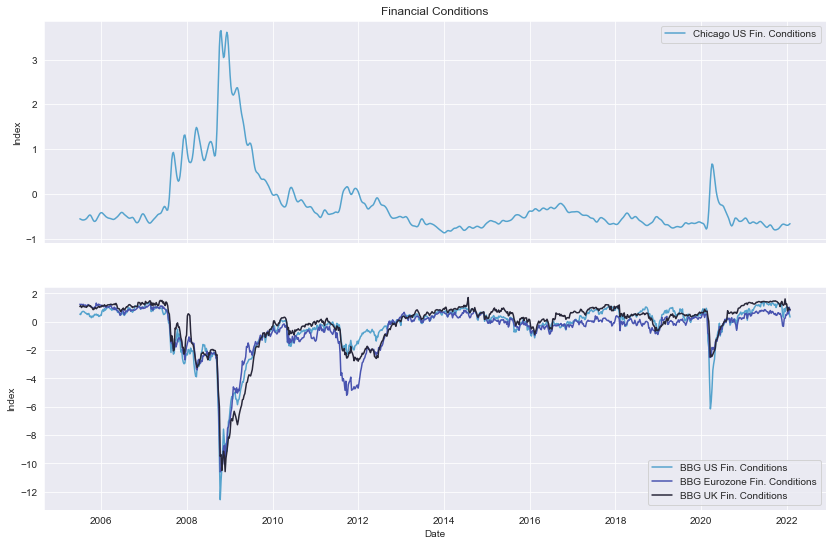

In [49]:
# Let's visualise these trends
fig, axes = plt.subplots(nrows=2, figsize=(14,9), sharex=True, sharey=False)
sns.lineplot(data=finc, x='date', y='chicago_fed_finc', ax=axes[0], 
             color=sns.color_palette("icefire")[0], label="Chicago US Fin. Conditions")

sns.lineplot(data=finc, x='date', y='bbg_us', ax=axes[1], 
             color=sns.color_palette("icefire")[0], label="BBG US Fin. Conditions")

sns.lineplot(data=finc, x='date', y='bbg_eu', ax=axes[1], 
             color=sns.color_palette("icefire")[1], label="BBG Eurozone Fin. Conditions")

sns.lineplot(data=finc, x='date', y='bbg_uk', ax=axes[1], 
             color=sns.color_palette("icefire")[2], label="BBG UK Fin. Conditions")

axes[0].set_title("Financial Conditions")
axes[0].legend()
axes[1].legend()

axes[0].set_ylabel("Index")
axes[1].set_ylabel("Index")
plt.xlabel("Date")
plt.show()

#### Commodities

In [50]:
# Read .xlsx containing US rates
como = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="como", skiprows=11)
print(como.shape)
como.head()

(866, 7)


,date,bco_men,bcom_in,bcom_pm,brent,wti,gold
0,2005-07-01,645.172,174.355,132.580,57.54,58.75,427.40
1,2005-07-08,663.429,182.597,132.192,58.20,59.63,423.10
2,2005-07-15,662.739,183.712,131.483,57.61,58.09,421.55
3,2005-07-22,645.242,185.505,133.047,57.58,58.65,425.00
4,2005-07-29,672.666,188.973,134.974,59.37,60.57,429.80


In [51]:
# Standardise dates for compilation later
como['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in como['date']]

In [52]:
# Setting date as our index
como.set_index('date', inplace=True)

In [53]:
# Calculating 4-week differences
como_4w = como.pct_change(4)*100

# Calculating quarterly changes (13-week) differences
como_13w = como.pct_change(13)*100

# Calculating half-yearly changes (26-week) differences
como_26w = como.pct_change(26)*100

In [54]:
# We will combine the dataframes above and add suffixes
como_tidied = pd.concat([como_4w.add_suffix("_4w_chg"), 
                        como_13w.add_suffix("_13w_chg"), 
                        como_26w.add_suffix("_26w_chg")], axis=1)

In [55]:
# Preview dataframe
como_tidied.tail()

,bco_men_4w_chg,bcom_in_4w_chg,bcom_pm_4w_chg,brent_4w_chg,wti_4w_chg,gold_4w_chg,bco_men_13w_chg,bcom_in_13w_chg,bcom_pm_13w_chg,brent_13w_chg,wti_13w_chg,gold_13w_chg,bco_men_26w_chg,bcom_in_26w_chg,bcom_pm_26w_chg,brent_26w_chg,wti_26w_chg,gold_26w_chg
date,,,,,,,,,,,,,,,,,,
2021-12-31,5.420677,6.662672,2.795816,11.305094,13.507395,2.574455,-12.408195,7.784071,3.781986,-1.892028,-0.882973,3.873979,3.182640,10.655375,-1.203815,2.113693,0.066525,2.344318
2022-01-07,6.509102,6.627093,0.764843,8.782435,10.087903,0.768998,-10.480234,4.303911,1.388041,-0.776793,-0.567108,2.243431,8.946636,10.958467,-4.263725,8.206486,5.820815,-0.650880
2022-01-14,16.696852,6.755923,0.884334,17.056583,18.289585,1.102825,-6.255416,-3.713180,1.626039,1.414094,1.871658,2.846766,18.201364,12.856709,-2.799012,16.945237,16.724690,0.325046
2022-01-21,12.727790,7.105604,2.333304,15.432099,15.381488,1.387646,-6.334126,6.931683,1.485981,2.759266,1.647564,2.383622,13.801689,16.042698,0.320742,18.609987,18.135146,1.843909
2022-01-28,19.525342,3.494179,-2.874197,15.749550,15.436777,-2.059370,1.845333,7.546254,-1.631590,6.695900,3.888955,0.456997,21.114418,10.344883,-4.454884,17.948382,17.403651,-1.249042


#### US rates

In [56]:
# Read .xlsx containing p/b ratios for a variety of indices
us_ir = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="us_yields", skiprows=11)
print(us_ir.shape)
us_ir.head()

(866, 6)


,date,us_3m,us_2y,us_5y,us_10y,us_30y
0,2005-07-01,3.1562,3.7401,3.8240,4.0489,4.2942
1,2005-07-08,3.1668,3.7657,3.8775,4.0914,4.3413
2,2005-07-15,3.2388,3.8591,3.9724,4.1635,4.3963
3,2005-07-22,3.3624,3.9036,4.0322,4.2185,4.4399
4,2005-07-29,3.3933,4.0147,4.1210,4.2760,4.4706


In [57]:
# Standardise dates for compilation later
us_ir['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in us_ir['date']]

In [58]:
# Setting date as our index
us_ir.set_index('date', inplace=True)

In [59]:
# Calculate 10s2s yield curve
us_ir['us_10y2ys'] = us_ir['us_10y'] - us_ir['us_2y']

# Calculate 30s2s yield curve
us_ir['us_30y2ys'] = us_ir['us_30y'] - us_ir['us_2y']

In [60]:
# Calculating 1-week differences
us_ir_1w = us_ir.diff(1)

# Calculating 4-week differences
us_ir_4w = us_ir.diff(4)

# Calculating quarterly changes (13-week) differences
us_ir_13w = us_ir.diff(13)

# Calculating half-yearly changes (26-week) differences
us_ir_26w = us_ir.diff(26)

In [61]:
# We will combine the dataframes above and add suffixes
us_ir_tidied = pd.concat([us_ir_1w.add_suffix("_1w_chg"), 
                        us_ir_4w.add_suffix("_4w_chg"), 
                        us_ir_13w.add_suffix("_13w_chg"), 
                        us_ir_26w.add_suffix("_26w_chg")], axis=1)

In [62]:
# Preview dataframe
us_ir_tidied.tail()

,us_3m_1w_chg,us_2y_1w_chg,us_5y_1w_chg,us_10y_1w_chg,us_30y_1w_chg,us_10y2ys_1w_chg,us_30y2ys_1w_chg,us_3m_4w_chg,us_2y_4w_chg,us_5y_4w_chg,...,us_30y_13w_chg,us_10y2ys_13w_chg,us_30y2ys_13w_chg,us_3m_26w_chg,us_2y_26w_chg,us_5y_26w_chg,us_10y_26w_chg,us_30y_26w_chg,us_10y2ys_26w_chg,us_30y2ys_26w_chg
date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,-0.0254,0.0441,0.0213,0.0174,-0.0020,-0.0267,-0.0461,-0.0127,0.1449,0.1310,...,-0.1255,-0.4199,-0.5939,-0.0076,0.4986,0.4057,0.0863,-0.1372,-0.4123,-0.6358
2022-01-07,0.0609,0.1299,0.2357,0.2519,0.2127,0.1220,0.0828,0.0431,0.2078,0.2487,...,-0.0481,-0.3941,-0.5924,0.0482,0.6495,0.7137,0.4025,0.1270,-0.2470,-0.5225
2022-01-14,0.0203,0.1047,0.0590,0.0221,0.0060,-0.0826,-0.0987,0.0812,0.3292,0.3828,...,0.0805,-0.3581,-0.4914,0.0685,0.7453,0.7843,0.4938,0.2027,-0.2515,-0.5426
2022-01-21,0.0481,0.0346,-0.0006,-0.0260,-0.0509,-0.0606,-0.0855,0.1039,0.3133,0.3154,...,0.0027,-0.4223,-0.5453,0.1166,0.8033,0.8453,0.4818,0.1559,-0.3215,-0.6474
2022-01-28,0.0153,0.1609,0.0556,0.0113,0.0023,-0.1496,-0.1586,0.1446,0.4301,0.3497,...,0.1405,-0.4480,-0.5248,0.1344,0.9784,0.9223,0.5471,0.1811,-0.4313,-0.7973


#### EU rates

In [63]:
# Read .xlsx containing EU rates
eu_ir = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="eu_yields", skiprows=11)
print(eu_ir.shape)
eu_ir.head()

(866, 6)


,date,eu_3m,eu_2y,eu_5y,eu_10y,eu_30y
0,2005-07-01,2.121,2.029,2.516,3.157,3.675
1,2005-07-08,2.136,2.077,2.567,3.181,3.691
2,2005-07-15,2.110,2.124,2.664,3.283,3.801
3,2005-07-22,2.119,2.116,2.614,3.231,3.746
4,2005-07-29,2.132,2.146,2.647,3.243,3.738


In [64]:
# Standardise dates for compilation later
eu_ir['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in eu_ir['date']]

In [65]:
# Setting date as our index
eu_ir.set_index('date', inplace=True)

In [66]:
# Calculate 10s2s yield curve
eu_ir['eu_10y2ys'] = eu_ir['eu_10y'] - eu_ir['eu_2y']

# Calculate 30s2s yield curve
eu_ir['eu_30y2ys'] = eu_ir['eu_30y'] - eu_ir['eu_2y']

In [67]:
# Calculating 1-week differences
eu_ir_1w = eu_ir.diff(1)

# Calculating 4-week differences
eu_ir_4w = eu_ir.diff(4)

# Calculating quarterly changes (13-week) differences
eu_ir_13w = eu_ir.diff(13)

# Calculating half-yearly changes (26-week) differences
eu_ir_26w = eu_ir.diff(26)

In [68]:
# We will combine the dataframes above and add suffixes
eu_ir_tidied = pd.concat([eu_ir_1w.add_suffix("_1w_chg"), 
                        eu_ir_4w.add_suffix("_4w_chg"), 
                        eu_ir_13w.add_suffix("_13w_chg"), 
                        eu_ir_26w.add_suffix("_26w_chg")], axis=1)

In [69]:
# Previewing our dataframe
eu_ir_tidied.tail()

,eu_3m_1w_chg,eu_2y_1w_chg,eu_5y_1w_chg,eu_10y_1w_chg,eu_30y_1w_chg,eu_10y2ys_1w_chg,eu_30y2ys_1w_chg,eu_3m_4w_chg,eu_2y_4w_chg,eu_5y_4w_chg,...,eu_30y_13w_chg,eu_10y2ys_13w_chg,eu_30y2ys_13w_chg,eu_3m_26w_chg,eu_2y_26w_chg,eu_5y_26w_chg,eu_10y_26w_chg,eu_30y_26w_chg,eu_10y2ys_26w_chg,eu_30y2ys_26w_chg
date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,-0.031,-0.019,0.060,0.071,0.078,0.090,0.097,0.254,0.102,0.176,...,-0.063,0.027,-0.080,-0.066,-0.019,0.145,0.054,-0.080,0.073,-0.061
2022-01-07,0.092,0.005,0.078,0.137,0.083,0.132,0.078,0.266,0.097,0.202,...,-0.054,0.086,-0.075,0.029,0.016,0.216,0.249,0.071,0.233,0.055
2022-01-14,-0.021,-0.002,0.016,-0.003,-0.025,-0.001,-0.023,0.187,0.006,0.247,...,-0.029,0.094,-0.056,-0.006,0.004,0.272,0.307,0.121,0.303,0.117
2022-01-21,-0.010,-0.013,0.032,-0.019,-0.021,-0.006,-0.008,0.030,-0.029,0.186,...,-0.008,0.033,-0.015,-0.003,-0.018,0.370,0.354,0.170,0.372,0.188
2022-01-28,0.004,-0.004,0.027,0.020,0.009,0.024,0.013,0.065,-0.014,0.153,...,0.102,0.050,0.092,0.002,-0.014,0.436,0.415,0.220,0.429,0.234


In [70]:
# Read .xlsx containing credit spreads
credit = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="credit", skiprows=11)
print(credit.shape)
credit.head()

(866, 6)


,date,global_hy,us_hy,us_baa,em_usd,asia_usd
0,2005-07-01,3.557822,3.555562,1.307583,293.048,293.048
1,2005-07-08,3.496744,3.484558,1.304111,288.285,288.285
2,2005-07-15,3.349663,3.291966,1.251280,279.632,279.632
3,2005-07-22,3.310643,3.244820,1.235336,281.335,281.335
4,2005-07-29,3.209760,3.103038,1.193913,273.649,273.649


In [71]:
# Standardise dates for compilation later
credit['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in credit['date']]

In [72]:
# Setting date as our index
credit.set_index('date', inplace=True)

In [73]:
# Standardising EM USD credit spreads as % (instead of bps)
credit['em_usd'] = credit['em_usd']/100

In [74]:
# Calculating spreads between US high-yield and US investment-grade bonds (Not adjusted for duration)
credit['us_hy_baa_spread'] = credit['us_hy'] - credit['us_baa']

In [75]:
# Calculating 1-week differences
credit_1w = credit.diff(1)

# Calculating 4-week differences
credit_4w = credit.diff(4)

# Calculating quarterly changes (13-week) differences
credit_13w = credit.diff(13)

# Calculating half-yearly changes (26-week) differences
credit_26w = credit.diff(26)

In [76]:
# We will combine the dataframes above and add suffixes
credit_tidied = pd.concat([credit_1w.add_suffix("_1w_chg"), 
                        credit_4w.add_suffix("_4w_chg"), 
                        credit_13w.add_suffix("_13w_chg"), 
                        credit_26w.add_suffix("_26w_chg")], axis=1)

In [77]:
# Preview dataframe
credit_tidied.tail()

,global_hy_1w_chg,us_hy_1w_chg,us_baa_1w_chg,em_usd_1w_chg,asia_usd_1w_chg,us_hy_baa_spread_1w_chg,global_hy_4w_chg,us_hy_4w_chg,us_baa_4w_chg,em_usd_4w_chg,...,us_baa_13w_chg,em_usd_13w_chg,asia_usd_13w_chg,us_hy_baa_spread_13w_chg,global_hy_26w_chg,us_hy_26w_chg,us_baa_26w_chg,em_usd_26w_chg,asia_usd_26w_chg,us_hy_baa_spread_26w_chg
date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,-0.015460,0.004797,-0.032242,-0.04467,-4.467,0.037039,-0.484246,-0.430224,-0.086742,-0.17282,...,0.085451,0.07788,7.788,-0.184780,0.362361,0.158116,0.112344,0.25004,25.004,0.045772
2022-01-07,0.043452,0.151315,-0.001418,-0.02097,-2.097,0.152733,-0.196987,-0.039054,-0.039221,-0.00191,...,0.065458,0.10333,10.333,-0.039062,0.357366,0.292921,0.086584,0.18523,18.523,0.206337
2022-01-14,0.035092,-0.054172,0.034993,0.15676,15.676,-0.089165,-0.274881,-0.151183,-0.029494,0.04503,...,0.120657,0.27962,27.962,-0.086598,0.310986,0.109835,0.107848,0.31319,31.319,0.001987
2022-01-21,0.128202,0.193202,0.043328,0.03820,3.820,0.149874,0.191286,0.295142,0.044661,0.12932,...,0.155525,0.32751,32.751,0.113115,0.334692,0.226532,0.147928,0.31571,31.571,0.078604
2022-01-28,0.226666,0.332881,0.072267,0.02990,2.990,0.260614,0.433412,0.623226,0.149170,0.20389,...,0.214573,0.33770,33.770,0.371992,0.469866,0.509074,0.222413,0.31952,31.952,0.286661


#### AAII sentiment

In [78]:
# Read .xlsx containing AAII sentiment data
aaii = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="aaii", skiprows=11)
print(aaii.shape)
aaii.head()

(865, 4)


,date,aaii_bull,aaii_bear,aaii_neut
0,2005-07-07,43.01,20.43,36.56
1,2005-07-14,57.89,14.04,28.07
2,2005-07-21,41.18,27.45,31.37
3,2005-07-28,57.52,17.65,24.84
4,2005-08-04,47.83,26.09,26.09


In [79]:
# Standardise dates for compilation later
aaii['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in aaii['date']]

In [80]:
# Melting our dataframe
aaii.rename(columns={"aaii_bull": "Bullish", "aaii_bear": "Bearish","aaii_neut": "Neutral"}, inplace=True)

aaii_melt = aaii.melt(id_vars="date", var_name="type", value_name="sentiment")

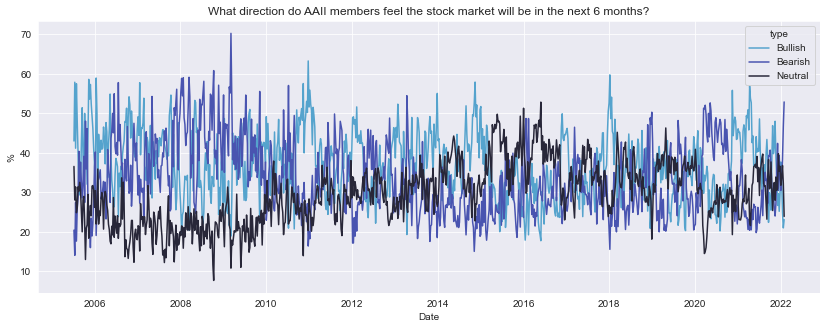

In [81]:
# Let's visualise the distributions of P/B ratios
fig, axes = plt.subplots(nrows=1, figsize=(14,5), sharex=True, sharey=False)
sns.lineplot(data=aaii_melt, x="date", y="sentiment", hue="type") 
plt.title("What direction do AAII members feel the stock market will be in the next 6 months?")
plt.xlabel("Date")
plt.ylabel("%")
plt.show()

In [82]:
# Setting date as our index
aaii.set_index('date', inplace=True)

In [83]:
# Preview dataframe
aaii.tail()

,Bullish,Bearish,Neutral
date,,,
2021-12-31,37.7,30.5,31.8
2022-01-07,32.8,33.3,33.9
2022-01-14,24.9,38.3,36.8
2022-01-21,21.0,46.7,32.3
2022-01-28,23.1,52.9,23.9


#### Breadth

In [84]:
# Read .xlsx containing % of index members with new 52-week highs
pct52w_h = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="pct52w", skiprows=11)
print(pct52w_h.shape)
pct52w_h.head()

(866, 7)


,date,spx,sx5e,ftse100,tpx,msci_axj,msci_acw
0,2005-07-01,5.6,12.0,9.80,5.16,4.37,7.52
1,2005-07-08,12.4,8.0,8.91,3.58,3.89,8.24
2,2005-07-15,6.4,18.0,3.96,6.01,8.29,7.96
3,2005-07-22,8.0,16.0,7.84,1.52,10.13,8.52
4,2005-07-29,10.4,20.0,17.65,8.02,10.93,12.39


In [85]:
# Standardise dates for compilation later
pct52w_h['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in pct52w_h['date']]

In [86]:
# Setting date as our index
pct52w_h.set_index('date', inplace=True)

#### CFTC net non-commercical positioning

In [87]:
# Read .xlsx containing AAII sentiment data
cftc = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="us_cftc", skiprows=11)
print(cftc.shape)
cftc.tail()

(865, 5)


,date,cftc_nc_net,cftc_nc_long,cftc_nc_short,cftc_oi
860,2021-12-28,103294,403614,300320,2287852
861,2022-01-04,109032,407706,298674,2297290
862,2022-01-11,77406,389727,312321,2283672
863,2022-01-18,125229,408370,283141,2309982
864,2022-01-25,226847,462479,235632,2378857


In [88]:
# Standardise dates for compilation later
cftc['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in cftc['date']]

In [89]:
# Setting date as our index
cftc.set_index('date', inplace=True)

In [90]:
# Calculating net positioning as a % of OI
cftc['cftc_nc_net_pct_oi'] = cftc['cftc_nc_net'] / cftc['cftc_oi'] * 100

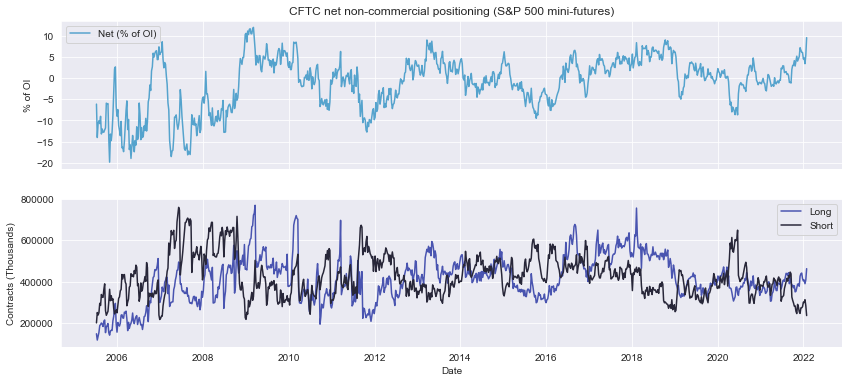

In [98]:
# Let's visualise these trends
fig, axes = plt.subplots(nrows=2, figsize=(14,6), sharex=True, sharey=False)
sns.lineplot(data=cftc, x='date', y='cftc_nc_net_pct_oi', ax=axes[0], 
             color=sns.color_palette("icefire")[0], label="Net (% of OI)")

sns.lineplot(data=cftc, x='date', y='cftc_nc_long', ax=axes[1], 
             color=sns.color_palette("icefire")[1], label="Long")

sns.lineplot(data=cftc, x='date', y='cftc_nc_short', ax=axes[1], 
             color=sns.color_palette("icefire")[2], label="Short")

axes[0].set_title("CFTC net non-commercial positioning (S&P 500 mini-futures)")
axes[0].legend()
axes[1].legend()

axes[0].set_ylabel("% of OI")
axes[1].set_ylabel("Contracts (Thousands)")
plt.xlabel("Date")
plt.show()

In [91]:
# Preview dataframe
cftc.tail()

,cftc_nc_net,cftc_nc_long,cftc_nc_short,cftc_oi,cftc_nc_net_pct_oi
date,,,,,
2021-12-31,103294,403614,300320,2287852,4.514890
2022-01-07,109032,407706,298674,2297290,4.746114
2022-01-14,77406,389727,312321,2283672,3.389541
2022-01-21,125229,408370,283141,2309982,5.421211
2022-01-28,226847,462479,235632,2378857,9.535966


#### Put-call ratios

In [93]:
# Read .xlsx containing S&P 500 put-call ratios
putcall = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="put_call", skiprows=11)
print(putcall.shape)
putcall.head()

(866, 2)


,date,cboe_us
0,2005-07-01,0.55
1,2005-07-08,0.42
2,2005-07-15,0.54
3,2005-07-22,0.56
4,2005-07-29,0.66


In [ ]:
# Standardise dates for compilation later
putcall['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in putcall['date']]

In [99]:
# Setting date as our index
putcall.set_index('date', inplace=True)

#### Economic policy uncertainty indices

In [101]:
# Read .xlsx containing Economic policy uncertainty indices
epu = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="epu", skiprows=11)
print(epu.shape)
epu.head()

(866, 2)


,date,us_epu
0,2005-07-03,82.37
1,2005-07-10,55.15
2,2005-07-17,24.92
3,2005-07-24,39.17
4,2005-07-31,35.30


In [103]:
# Standardise dates for compilation later
epu['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in epu['date']]

In [104]:
# Setting date as our index
epu.set_index('date', inplace=True)

#### USD indices (Trade-weighted USD, DXY, BBDXY)

In [111]:
# Read .xlsx containing Economic policy uncertainty indices
usd = pd.read_excel("../data/spx_fundamentals_values.xlsx", sheet_name="usd", skiprows=11)
print(usd.shape)
usd.head()

(866, 4)


,date,usd_twi,usd_dxy,usd_bbdxy
0,2005-07-01,102.2263,90.13,90.13
1,2005-07-08,102.2674,90.25,90.25
2,2005-07-15,101.7514,89.72,89.72
3,2005-07-22,101.1952,89.64,89.64
4,2005-07-29,101.2856,89.35,89.35


In [112]:
# Standardise dates for compilation later
usd['date'] = [(i - timedelta(days=i.weekday()) + timedelta(days=4)) for i in usd['date']]

In [113]:
# Setting date as our index
usd.set_index('date', inplace=True)

In [114]:
# Calculating 1-week differences
usd_1w = usd.pct_change(1)

# Calculating 4-week differences
usd_4w = usd.pct_change(4)

# Calculating quarterly changes (13-week) differences
usd_13w = usd.pct_change(13)

# Calculating half-yearly changes (26-week) differences
usd_26w = usd.pct_change(26)

In [115]:
# We will combine the dataframes above and add suffixes
usd_tidied = pd.concat([usd_1w.add_suffix("_1w_chg"), 
                        usd_4w.add_suffix("_4w_chg"), 
                        usd_13w.add_suffix("_13w_chg"), 
                        usd_26w.add_suffix("_26w_chg")], axis=1)

### List of sub-dataset(s)
* ```eri_tidied```: S&P 500 earnings revision
* ```cesi_tidied```: Citi economic surprise indices (1w, 1m, 3m, 6m changes)
* ```prices_4w_return```: 4-week rolling percentage returns of various indices (Lagged)
* ```vol```: Volatility indices
* ```fpe_tidied```: 12-month forward P/E ratios (1m, 3m, 6m % changes)
* ```fpb_tidied```: 12-month forward P/B ratios (1m, 3m, 6m % changes); **May need to be adjusted**
* ```finc```: Financial condition indices; **Chicago Fed Financial Conditions are inverted relative to the BBG ones**
* ```como```: Commodity front-end contracts and total return indices (1m, 3m, 6m % changes)
* ```us_ir_tidied```: US interest rates, including 10y/2y and 30y/2y spreads (1w, 1m, 3m, 6m changes)
* ```eu_ir_tidied```: Eurozone interest rates, including 10y/2y and 30y/2y spreads (1w, 1m, 3m, 6m changes)
* ```aaii```: AAII investor sentiment survey
* ```credit_tidied```: Credit spreads (1w, 1m, 3m, 6m changes; In %)
* ```pct52w_h```: Breadth data; Percentage of index members with new 52-week highs
* ```cftc```: CFTC net non-commercial data for S&P 500 mini-futures
* ```putcall```: Put-call ratios for S&P 500
* ```epu```: Economic policy uncertainty indices
* ```usd_tidied```: USD indices (Trade-weighted, DXY, BBDXY)

In [125]:
merged = pd.concat([eri_tidied, cesi_tidied, vol, fpe_tidied, fpb_tidied,
                   finc, como, us_ir_tidied, eu_ir_tidied, aaii, credit_tidied,
                   pct52w_h, cftc, putcall, epu, usd_tidied], axis=1)

In [130]:
print(merged.shape)

# Preview dataframe
merged.tail()

(866, 185)


,eri,eri_1m_chg,eri_3m_chg,cesiusd_1w_chg,cesieur_1w_chg,cesigbp_1w_chg,cesijpy_1w_chg,cesicny_1w_chg,cesiglf_1w_chg,cesiusd_4w_chg,...,usd_bbdxy_1w_chg,usd_twi_4w_chg,usd_dxy_4w_chg,usd_bbdxy_4w_chg,usd_twi_13w_chg,usd_dxy_13w_chg,usd_bbdxy_13w_chg,usd_twi_26w_chg,usd_dxy_26w_chg,usd_bbdxy_26w_chg
date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,0.622625,0.079658,-0.881191,-4.1,3.2,-14.7,16.0,-1.3,8.0,-14.1,...,-0.003635,-0.007985,-0.004651,-0.004651,0.007927,0.017387,0.017387,0.024156,0.037343,0.037343
2022-01-07,NaN,NaN,NaN,-15.9,10.7,0.7,2.6,5.8,-1.9,-31.4,...,0.000512,-0.004341,-0.003934,-0.003934,0.004141,0.017562,0.017562,0.019731,0.038956,0.038956
2022-01-14,NaN,NaN,NaN,-6.5,-4.6,10.1,16.0,-2.8,-6.4,-28.8,...,-0.005788,-0.011940,-0.014498,-0.014498,0.002616,0.013073,0.013073,0.011956,0.026735,0.026735
2022-01-21,NaN,NaN,NaN,-0.5,4.5,-16.7,7.3,22.5,8.1,-27.0,...,0.005012,-0.007824,-0.003926,-0.003926,0.008332,0.021358,0.021358,0.010411,0.029383,0.029383
2022-01-28,NaN,NaN,NaN,0.7,10.3,-9.3,8.6,-3.2,14.5,-22.2,...,0.017022,0.006481,0.016724,0.016724,0.016572,0.033435,0.033435,0.029866,0.055287,0.055287


In [131]:
# Write to csv - Selected features
merged.to_csv('../data/selected_features.csv')

In [132]:
# Write to csv - Target variable (4-weekly returns)
prices_4w_return.to_csv('../data/monthly_returns.csv')